# Exploratory Data Analysis

The first step in any data science project is to getting know the data we work with.

In this notebook you can see a basic explanatory data analysis on fraud-demo datasets.

We will perform a basic statistical analysis that will help us to understand the behaviors of each feature and also examine and find outliers.

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import math
import IPython
sns.set()

First we will load the data and immediately after that, as you can see, we will take a look of small portion of the data just to try and understand what it is about. After that we will start and examine it is main properties:
1. The size of the data.
2. The different types of features.

In [21]:
import pandas as pd
from src.date_adjust import adjust_data_timespan

# Fetch the transactions dataset from the server
transactions_data = pd.read_csv('https://s3.wasabisys.com/iguazio/data/fraud-demo-mlrun-fs-docs/data.csv', parse_dates=['timestamp'])

# use only first 10k
transactions_data = transactions_data.sort_values(by='source', axis=0)[:10000]

# Adjust the samples timestamp for the past 2 days
transactions_data = adjust_data_timespan(transactions_data, new_period='2d')

# Sorting after adjusting timestamps
transactions_data = transactions_data.sort_values(by='timestamp', axis=0)
transactions_data['age'] = transactions_data['age'].astype(np.int)

# Preview
transactions_data.head(3)

<ipython-input-21-c3e732f551cf>:15: DeprecationWarning:

`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



,step,age,gender,zipcodeOri,zipMerchant,category,amount,fraud,timestamp,source,target,device
274633,91,5,F,28007,28007,es_transportation,26.92,0,2023-06-19 10:53:31.471373000,C1022153336,M1823072687,33832bb8607545df97632a7ab02d69c4
286902,94,2,M,28007,28007,es_transportation,48.22,0,2023-06-19 10:53:49.764998913,C1006176917,M348934600,fadd829c49e74ffa86c8da3be75ada53
416998,131,3,M,28007,28007,es_transportation,17.56,0,2023-06-19 10:53:54.872168939,C1010936270,M348934600,58d0422a50bc40c89d2b4977b2f1beea


In [22]:
# Fetch the user_events dataset from the server
user_events_data = pd.read_csv('https://s3.wasabisys.com/iguazio/data/fraud-demo-mlrun-fs-docs/events.csv', 
                               index_col=0, quotechar="\'", parse_dates=['timestamp'])

# Adjust to the last 2 days to see the latest aggregations in the online feature vectors
user_events_data = adjust_data_timespan(user_events_data, new_period='2d')
user_events_data = user_events_data.sort_values(by='timestamp', axis=0)
user_events_data.head()

,source,event,timestamp
45553,C137986193,password_change,2023-06-19 10:53:33.726431000
24134,C1940951230,details_change,2023-06-19 10:53:34.774613091
64444,C247537602,login,2023-06-19 10:53:36.429396103
20434,C470079617,password_change,2023-06-19 10:53:37.719845428
26703,C1142118359,login,2023-06-19 10:53:38.510137830


In [23]:
all_data  = pd.merge_asof(
    transactions_data,
    user_events_data,
    on='timestamp',
    by='source',
)

all_data.head()

,step,age,gender,zipcodeOri,zipMerchant,category,amount,fraud,timestamp,source,target,device,event
0,91,5,F,28007,28007,es_transportation,26.92,0,2023-06-19 10:53:31.471373000,C1022153336,M1823072687,33832bb8607545df97632a7ab02d69c4,NaN
1,94,2,M,28007,28007,es_transportation,48.22,0,2023-06-19 10:53:49.764998913,C1006176917,M348934600,fadd829c49e74ffa86c8da3be75ada53,NaN
2,131,3,M,28007,28007,es_transportation,17.56,0,2023-06-19 10:53:54.872168939,C1010936270,M348934600,58d0422a50bc40c89d2b4977b2f1beea,NaN
3,108,4,F,28007,28007,es_transportation,4.50,0,2023-06-19 10:54:07.164920118,C1033736586,M1823072687,30b269ae55984e5584f1dd5f642ac1a3,NaN
4,72,4,M,28007,28007,es_transportation,1.83,0,2023-06-19 10:54:41.054002001,C1019071188,M348934600,97bee3503a984f59aa6139b59f933c0b,NaN


In [24]:
all_data.shape

(10000, 13)

In [25]:
all_data.dtypes

step                    int64
age                     int64
gender                 object
zipcodeOri              int64
zipMerchant             int64
category               object
amount                float64
fraud                   int64
timestamp      datetime64[ns]
source                 object
target                 object
device                 object
event                  object
dtype: object

Now we will start and examine the statistical characteristics of each feature, initial information that can give us different directions in finding outliers, dummies, etc.

In [26]:
all_data.describe()

,step,age,zipcodeOri,zipMerchant,amount,fraud
count,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00
mean,78.95,2.88,28007.00,28007.00,38.00,0.01
std,41.60,1.40,0.00,0.00,130.36,0.10
min,0.00,0.00,28007.00,28007.00,0.00,0.00
25%,44.00,2.00,28007.00,28007.00,13.57,0.00
50%,81.00,3.00,28007.00,28007.00,26.69,0.00
75%,115.00,4.00,28007.00,28007.00,42.36,0.00
max,147.00,6.00,28007.00,28007.00,7635.41,1.00


Another interesting thing is to see the distribution of other tagret to be able select our metrics better.

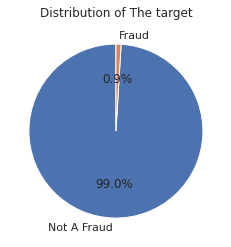

In [27]:
# Create the pie chart
plt.pie(all_data['fraud'].value_counts(), labels=['Not A Fraud', 'Fraud'], autopct='%1.1f%%', startangle=90)

# Add a title
plt.title('Distribution of The target')

# Display the chart
plt.show()

In [28]:
all_data['gender'].value_counts()

M    5448
F    4552
Name: gender, dtype: int64

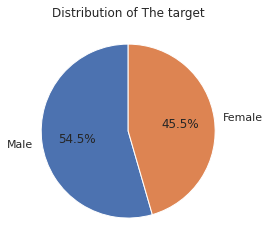

In [29]:
# Create the pie chart
plt.pie(all_data['gender'].value_counts(), labels=['Male', 'Female'], autopct='%1.1f%%', startangle=90)

# Add a title
plt.title('Distribution of The target')

# Display the chart
plt.show()

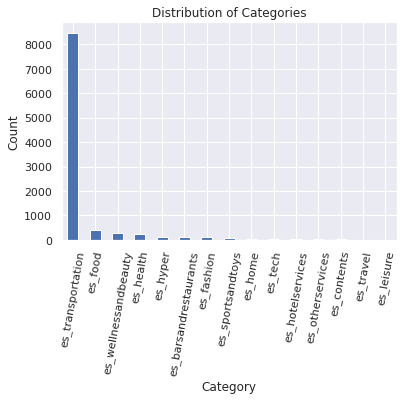

In [30]:
# Assuming you have a DataFrame called 'df' with a categorical column called 'category'

# Count the occurrences of each category
category_counts = all_data['category'].value_counts()

# Plot the results as a bar plot
category_counts.plot(kind='bar', )

# Set labels and title
plt.xlabel('Category')
plt.ylabel('Count')
plt.title('Distribution of Categories')
plt.xticks(rotation=80)

# Show the plot
plt.show()

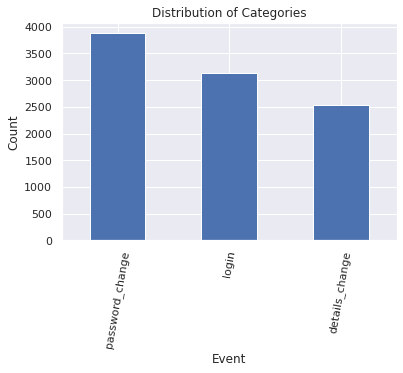

In [31]:
# Assuming you have a DataFrame called 'df' with a categorical column called 'category'

# Count the occurrences of each category
category_counts = all_data['event'].value_counts()

# Plot the results as a bar plot
category_counts.plot(kind='bar', )

# Set labels and title
plt.xlabel('Event')
plt.ylabel('Count')
plt.title('Distribution of Categories')
plt.xticks(rotation=80)

# Show the plot
plt.show()

In [32]:
all_data = pd.get_dummies(all_data, columns=['category', 'gender', 'event'])

When we have a dimension of time in the data, a good practice is to look at the distribution of features against our time, of course after breaking down the time into days, hours, months, etc.

Here you can see the distribution of the the fraud vs time.

In [33]:
all_data["timestamp"] = pd.to_datetime(
        all_data["timestamp"], format="%Y-%m-%d %H:%M:%S UTC"
    )

all_data["hour"] = all_data.timestamp.dt.hour
all_data["day"] = all_data.timestamp.dt.day
all_data["month"] = all_data.timestamp.dt.month
all_data["weekday"] = all_data.timestamp.dt.weekday
all_data["year"] = all_data.timestamp.dt.year

Text(0.5, 1.0, 'Count of fraud/not fraud for each hour')

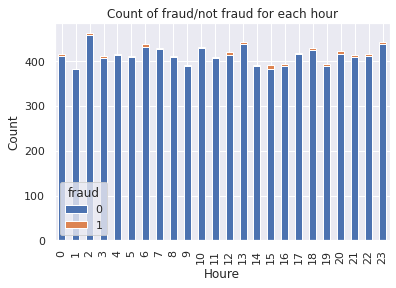

In [34]:
grouped = all_data.groupby('hour')['fraud'].value_counts().unstack().fillna(0)
# Plot the results
grouped.plot(kind='bar', stacked=True)

# Set labels and title
plt.xlabel('Houre')
plt.ylabel('Count')
plt.title('Count of fraud/not fraud for each hour')

Text(0.5, 1.0, 'Count of fraud/not fraud for each day of the week')

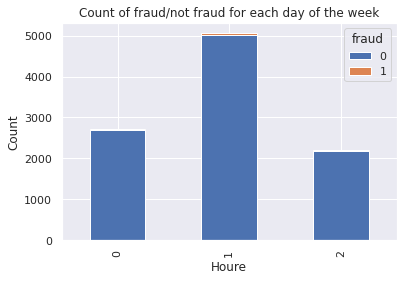

In [35]:
grouped = all_data.groupby('weekday')['fraud'].value_counts().unstack().fillna(0)
# Plot the results
grouped.plot(kind='bar', stacked=True)

# Set labels and title
plt.xlabel('Houre')
plt.ylabel('Count')
plt.title('Count of fraud/not fraud for each day of the week')

Correlation Matrix

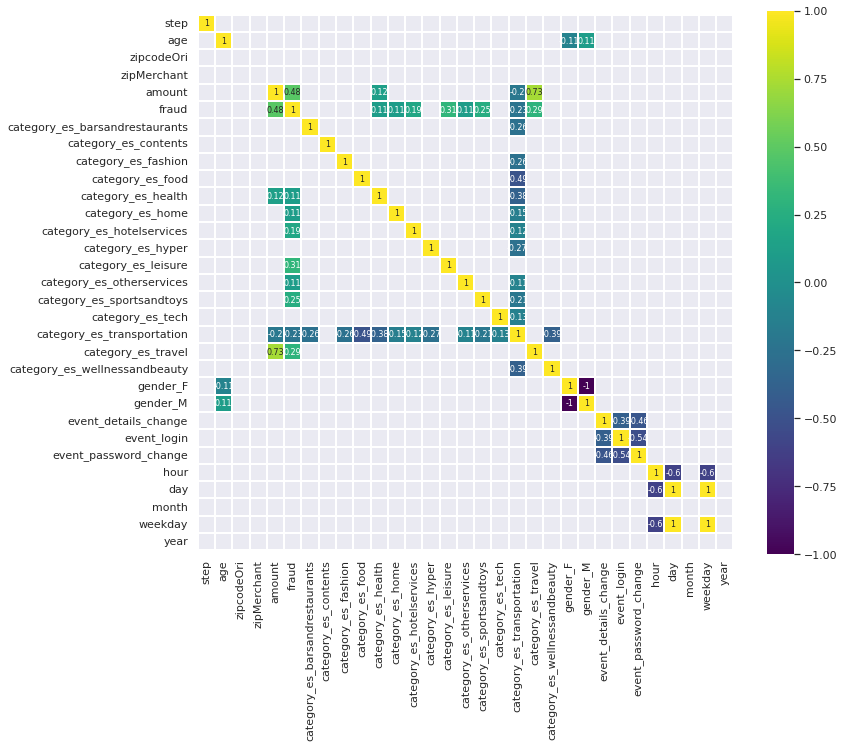

In [36]:
corr = all_data.corr()
plt.figure(figsize=(12, 10))

sns.heatmap(corr[(corr >= 0.1) | (corr <= -0.1)], 
            cmap='viridis', vmax=1.0, vmin=-1.0, linewidths=0.1,
            annot=True, annot_kws={"size": 8}, square=True);

### Analyis with MLRUN

You can see by simply running the describe function from our Market Place you can get a lot of information about the data and perform a qualitative and in-depth analysis on it.

In [37]:
all_data.to_csv('./data_set_describe.csv', index=False)


import mlrun

project = mlrun.get_or_create_project(
    name="fraud-eda", user_project=True, context="./"
)

# import the function
describe = mlrun.import_function('hub://describe')

describe_run = describe.run(params={'label_column': 'fraud',},
                            inputs={"table": './data_set_describe.csv'}, local=True)

> 2023-06-21 10:53:55,169 [info] Loaded project fraud-eda from ./ and saved in MLRun DB
> 2023-06-21 10:53:55,580 [info] Storing function: {'name': 'describe-analyze', 'uid': '3d275b269dc745a18df044e3e3dd8d8c', 'db': 'http://mlrun-api:8080'}
> 2023-06-21 10:54:01,618 [info] The data set is logged to the project under dataset name


project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
fraud-eda-admin,...e3dd8d8c,0,Jun 21 10:53:55,completed,describe-analyze,v3io_user=adminkind=owner=adminhost=jupyter-74c86b8866-d2vpm,table,label_column=fraud,,describe-csvhisthistogramsscatter-2dviolinimbalanceimbalance-weights-veccorrelation-matrix-csvcorrelationdataset


> 2023-06-21 10:54:02,013 [info] Run execution finished: {'status': 'completed', 'name': 'describe-analyze'}


#### Few examples for plots we get from mlrun describe function.

In [38]:
# view generated artifacts (charts)
describe_run.outputs

{'describe-csv': 'v3io:///projects/fraud-eda-admin/artifacts/describe-analyze/0/describe-csv.csv',
 'hist': 'store://artifacts/fraud-eda-admin/describe-analyze_hist:3d275b269dc745a18df044e3e3dd8d8c',
 'histograms': 'v3io:///projects/fraud-eda-admin/artifacts/describe-analyze/0/histograms.html',
 'scatter-2d': 'v3io:///projects/fraud-eda-admin/artifacts/describe-analyze/0/scatter-2d.html',
 'violin': 'v3io:///projects/fraud-eda-admin/artifacts/describe-analyze/0/violin.html',
 'imbalance': 'v3io:///projects/fraud-eda-admin/artifacts/describe-analyze/0/imbalance.html',
 'imbalance-weights-vec': 'v3io:///projects/fraud-eda-admin/artifacts/describe-analyze/0/imbalance-weights-vec.csv',
 'correlation-matrix-csv': 'v3io:///projects/fraud-eda-admin/artifacts/describe-analyze/0/correlation-matrix-csv.csv',
 'correlation': 'v3io:///projects/fraud-eda-admin/artifacts/describe-analyze/0/correlation.html',
 'dataset': 'store://artifacts/fraud-eda-admin/dataset:3d275b269dc745a18df044e3e3dd8d8c'}